# Описание проекта


Необходимо создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

### Краткое описание таблиц

- collisions — общая информация о ДТП.
Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП например, где оно произошло и когда.
- parties — информация об участниках ДТП.
Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id и party_number.
- vehicles — информация о пострадавших машинах.
Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id и party_number.

### Этапы решения задачи

1. Создать модель предсказания ДТП (целевое значение — at_fault в таблице parties);
2. Для модели выбрать тип виновника — только машина.
Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).Для моделирования ограничиться данными за 2012 год — они самые свежие.
Обязательное условие — учесть фактор возраста автомобиля;
3. На основе модели исследовать основные факторы ДТП;

# Загрузка библиотек и данных

Импорт библиотек

In [ ]:
!pip -q install -U scikit-learn
!pip -q install -U catboost
!pip -q install -U torch
!pip -q install -U optuna
!pip -q install -U skorch

In [ ]:
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer, StandardScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import torch
import torch.nn as nn

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

import optuna

Подключаемся к базе данных

In [ ]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)

Пробуем выгрузить таблицы

In [ ]:
query = '''
SELECT *
FROM collisions
LIMIT 100;
'''

df = pd.read_sql_query(query, con=engine)
df.sample(5)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
98,4083445,3313,riverside,60.0,east,0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-07,18:01:00
24,4083169,5690,ventura,43.0,west,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,functioning,2009-01-10,10:25:00
45,4083224,3012,orange,0.0,None,1,clear,intersection,scratch,2,vehicle code violation,wrong side of road,broadside,bicycle,dry,normal,daylight,functioning,2009-01-08,08:21:00
70,4083310,1975,los angeles,0.0,east,0,clear,None,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,15:57:00
37,4083195,3009,orange,100.0,east,0,cloudy,highway,scratch,3,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,dark with street lights,none,2009-01-25,20:00:00


In [ ]:
query = '''
SELECT *
FROM case_ids
LIMIT 100;
'''

case_ids = pd.read_sql_query(query, con=engine)
case_ids.sample(5)

,case_id,db_year
34,3899505,2021
14,3899465,2021
71,3982902,2021
47,3981318,2021
1,0726202,2021


In [ ]:
query = '''
SELECT *
FROM vehicles
LIMIT 100;
'''

df = pd.read_sql_query(query, con=engine)
df.sample(5)

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
69,1175906,5305188,2,sedan,manual,3.0
39,1194674,5324189,1,sedan,manual,8.0
2,1175712,5305030,1,sedan,auto,3.0
52,1175877,5305163,1,sedan,auto,3.0
38,1194669,5324178,1,sedan,manual,1.0


In [ ]:
query = '''
SELECT *
FROM parties
LIMIT 100;
'''

parties = pd.read_sql_query(query, con=engine)
parties.sample(5)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
47,383,3987616,2,road bumper,0,NaN,not applicable,not applicable,0.0
52,419,3987677,1,road bumper,1,NaN,had not been drinking,None,1.0
31,266,3984278,1,road signs,1,82.0,impairment unknown,G,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
19,222,3982945,1,building,1,47.0,had not been drinking,None,NaN


Пробуем выгрузить все данные

In [ ]:
query = '''
SELECT *
FROM collisions AS c
JOIN case_ids as ci on c.case_id = ci.case_id
JOIN vehicles as v on c.case_id = v.case_id
JOIN parties as p on c.case_id = p.case_id
LIMIT 100;
'''

df = pd.read_sql_query(query, con=engine)
df.sample(5)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,...,vehicle_age,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
74,4169339,3710,san diego,600.0,south,0,clear,None,scratch,2,...,2.0,155318,4169339,2,road signs,0,15.0,had not been drinking,None,0.0
53,4141553,4806,solano,252.0,west,0,None,None,small damage,4,...,3.0,119959,4141553,4,road bumper,0,NaN,not applicable,not applicable,0.0
64,4167714,4113,san mateo,0.0,None,1,clear,None,scratch,2,...,1.0,152866,4167714,1,building,1,21.0,had not been drinking,None,0.0
24,4096289,0106,alameda,0.0,None,1,cloudy,None,middle damage,6,...,6.0,56100,4096289,5,road bumper,0,NaN,not applicable,not applicable,NaN
55,4163557,0708,contra costa,650.0,east,0,clear,None,scratch,2,...,7.0,145864,4163557,2,building,0,49.0,"had been drinking, impairment unknown",None,0.0


**Вывод:** Все данные на месте

# Проведем статистический анализ факторов ДТП

## Выясним, в какие месяцы происходит наибольшее количество аварий.

Проанализируем весь период наблюдений (таблица collisions):
- Создадим sql-запрос;
- Построим график;

Посмотрим распределение по годам.

In [ ]:
query = '''
SELECT EXTRACT (YEAR FROM collision_date) as year,
       COUNT(*) as count
FROM collisions
GROUP BY EXTRACT (YEAR FROM collision_date)
'''

collisions = pd.read_sql_query(query, con=engine)
collisions

,year,count
0,2009.0,426228
1,2010.0,416490
2,2011.0,402428
3,2012.0,154547
4,2013.0,305
5,2020.0,2


После 2012 года данных очень мало, поэтому распредление по месяцам посмотрим до 2012 года.

In [ ]:
query = '''
SELECT EXTRACT (MONTH FROM collision_date) as month,
       COUNT(*) as count
FROM collisions
WHERE EXTRACT (YEAR FROM collision_date) < 2012
GROUP BY EXTRACT (MONTH FROM collision_date)
'''

collisions = pd.read_sql_query(query, con=engine)
collisions

,month,count
0,1.0,99880
1,2.0,98373
2,3.0,107036
3,4.0,101032
4,5.0,105148
5,6.0,99531
6,7.0,101835
7,8.0,103467
8,9.0,104649
9,10.0,111933


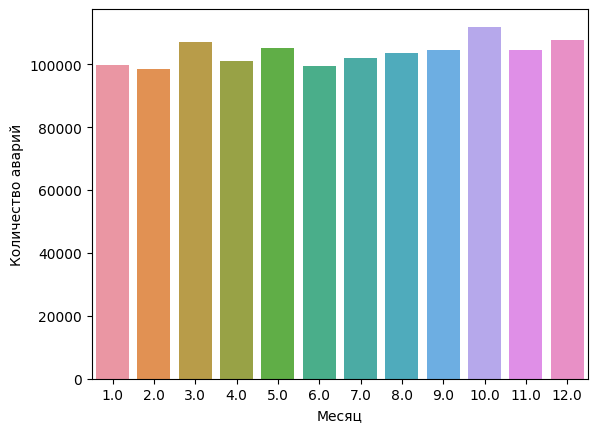

In [ ]:
sns.barplot(data=collisions, x='month', y='count')
plt.xlabel('Месяц')
plt.ylabel('Количество аварий')
plt.show()

Октябрь самый аварийный месяц.

# Модель для оценки водительского риска

Выгружаем следующие данные:

- Тип виновника — только машина (car);
- ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина);
- Данные только за 2012 год;

In [ ]:
query = '''
WITH t AS
(
  SELECT p.*,
         v.vehicle_type,
         v.vehicle_transmission,
         v.vehicle_age
  FROM vehicles as v
  JOIN parties as p ON p.case_id = v.case_id AND p.party_number = v.party_number
)
SELECT *
FROM t
LEFT JOIN collisions AS c ON t.case_id = c.case_id
WHERE t.party_type = 'car'
      AND c.collision_damage <> 'scratch'
      AND EXTRACT(year FROM c.collision_date) = 2012
'''

df = pd.read_sql_query(query, con=engine)
df.sample(5)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
10680,2626682,5582590,1,car,1,23.0,had not been drinking,None,0.0,sedan,...,vehicle code violation,unsafe starting or backing,hit object,fixed object,dry,normal,dark with street lights,none,2012-03-02,01:09:00
19856,2625445,5581871,2,car,0,60.0,had not been drinking,None,0.0,sedan,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2012-04-08,16:26:00
48443,2695384,5621072,1,car,1,26.0,had not been drinking,None,NaN,coupe,...,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,dry,normal,daylight,functioning,2012-05-02,17:40:00
37248,2661141,5602063,3,car,0,41.0,"had been drinking, under influence",None,0.0,sedan,...,vehicle code violation,dui,sideswipe,other motor vehicle,dry,normal,dark with street lights,none,2012-04-08,02:35:00
17313,2582331,5549650,2,car,0,44.0,had not been drinking,None,1.0,sedan,...,vehicle code violation,speeding,rear end,other motor vehicle,wet,normal,daylight,none,2012-03-13,16:45:00


Выгруженные признаки:

In [ ]:
df.columns

Index(['id', 'case_id', 'party_number', 'party_type', 'at_fault',
       'insurance_premium', 'party_sobriety', 'party_drug_physical',
       'cellphone_in_use', 'vehicle_type', 'vehicle_transmission',
       'vehicle_age', 'case_id', 'county_city_location', 'county_location',
       'distance', 'direction', 'intersection', 'weather_1', 'location_type',
       'collision_damage', 'party_count', 'primary_collision_factor',
       'pcf_violation_category', 'type_of_collision',
       'motor_vehicle_involved_with', 'road_surface', 'road_condition_1',
       'lighting', 'control_device', 'collision_date', 'collision_time'],
      dtype='object')

Отбор признаков для модели

In [ ]:
selected_columns = ['weather_1',
           'primary_collision_factor',
           'road_surface',
           'lighting',
           'distance',
           'location_type',
           'road_condition_1',
           'party_drug_physical',
           'party_sobriety',
           'cellphone_in_use',
           'vehicle_transmission',
           'vehicle_type',
           'vehicle_age',
           'at_fault'
]

In [ ]:
df = df[selected_columns]

## Предварительный анализ и обработка данных

In [ ]:
df = df.rename(columns={'weather_1': 'weather',
                        'road_condition_1': 'road_condition'}
)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   weather                   56080 non-null  object 
 1   primary_collision_factor  56137 non-null  object 
 2   road_surface              55900 non-null  object 
 3   lighting                  56094 non-null  object 
 4   distance                  56248 non-null  float64
 5   location_type             25932 non-null  object 
 6   road_condition            55999 non-null  object 
 7   party_drug_physical       2857 non-null   object 
 8   party_sobriety            55376 non-null  object 
 9   cellphone_in_use          51777 non-null  float64
 10  vehicle_transmission      55389 non-null  object 
 11  vehicle_type              56248 non-null  object 
 12  vehicle_age               54554 non-null  float64
 13  at_fault                  56248 non-null  int64  
dtypes: flo

In [ ]:
df.describe()

,distance,cellphone_in_use,vehicle_age,at_fault
count,5.624800e+04,51777.000000,54554.000000,56248.000000
mean,8.594387e+02,0.020357,4.856472,0.504427
std,7.240295e+03,0.141218,3.234503,0.499985
min,0.000000e+00,0.000000,0.000000,0.000000
25%,7.000000e+00,0.000000,3.000000,0.000000
50%,1.350000e+02,0.000000,4.000000,1.000000
75%,5.450000e+02,0.000000,7.000000,1.000000
max,1.584000e+06,1.000000,161.000000,1.000000


In [ ]:
df.isna().sum()

weather                       168
primary_collision_factor      111
road_surface                  348
lighting                      154
distance                        0
location_type               30316
road_condition                249
party_drug_physical         53391
party_sobriety                872
cellphone_in_use             4471
vehicle_transmission          859
vehicle_type                    0
vehicle_age                  1694
at_fault                        0
dtype: int64

In [ ]:
df.duplicated().sum()

17886

Убираем явные дубликаты

In [ ]:
df = df.drop_duplicates()

Подправим данные

In [ ]:
df = df[df.vehicle_age < 25]
df = df[df.distance < 100000]

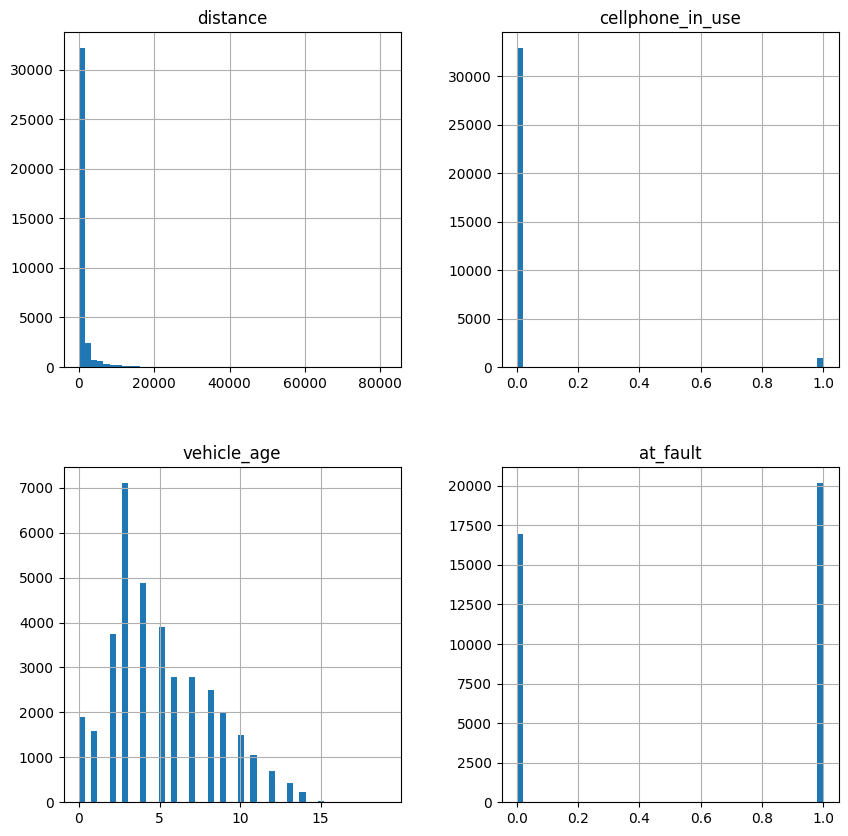

In [ ]:
df.hist(bins = 50, figsize=(10, 10));

Проверим значения в столбцах

In [ ]:
for column in df.columns:
    print(column)
    print(df[column].unique())
    print()

weather
['clear' 'cloudy' 'raining' 'fog' None 'wind' 'snowing' 'other']

primary_collision_factor
['unknown' 'vehicle code violation' 'other than driver'
 'other improper driving' None 'fell asleep']

road_surface
['dry' 'wet' None 'snowy' 'slippery']

lighting
['dark with no street lights' 'daylight' 'dark with street lights'
 'dusk or dawn' None 'dark with street lights not functioning']

distance
[5.0000e+02 5.2800e+02 2.1120e+03 ... 1.2330e+03 1.0100e+01 4.5936e+04]

location_type
['ramp' None 'highway' 'intersection']

road_condition
['normal' None 'flooded' 'construction' 'reduced width' 'loose material'
 'other' 'obstruction' 'holes']

party_drug_physical
[None 'under drug influence' 'G' 'sleepy/fatigued' 'impairment - physical'
 'not applicable']

party_sobriety
['had not been drinking' None 'had been drinking, under influence'
 'impairment unknown' 'had been drinking, not under influence'
 'had been drinking, impairment unknown' 'not applicable']

cellphone_in_use
[ 0. nan  1

Неявных дубликатов не обнаружено. Признаки содержат адекватные значения.

## Формируем признаки

In [ ]:
features = df.drop(columns=['at_fault'])
target = df['at_fault']

features_train, features_valid_and_test, target_train, target_valid_and_test = train_test_split(features, target,
                                                                              test_size=0.3, random_state=0)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_and_test, target_valid_and_test,
                                                                            test_size=0.333, random_state=0)
print(f'В обучающей выборке {len(features_train)/len(features):.1%} данных')
print(f'В валидационной выборке {len(features_valid)/len(features):.1%} данных')
print(f'В тестовой выборке {len(features_test)/len(features):.1%} данных')

В обучающей выборке 70.0% данных
В валидационной выборке 20.0% данных
В тестовой выборке 10.0% данных


In [ ]:
num_features = features.select_dtypes(include=('number')).columns.tolist()
cat_features = features.select_dtypes('object').columns.tolist()
num_features, cat_features

(['distance', 'cellphone_in_use', 'vehicle_age'],
 ['weather',
  'primary_collision_factor',
  'road_surface',
  'lighting',
  'location_type',
  'road_condition',
  'party_drug_physical',
  'party_sobriety',
  'vehicle_transmission',
  'vehicle_type'])

## Конструируем пайплайн

In [ ]:
def make_ct(model_type=None):

    num_pipeline = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=8)),
        ('scaler', MinMaxScaler(feature_range=(0, 1)))
        ]
    )
    if model_type == 'catboost':
        encoder = None
    else:
        encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

    cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown', missing_values = None)),
    ('one-hot', encoder)
        ]
    )

    return  ColumnTransformer(transformers=[('num', num_pipeline, num_features),
                                            ('cat', cat_pipeline, cat_features)],
                                            remainder='passthrough'
                            )

In [ ]:
class Preparer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(data=X, columns=num_features+cat_features)
        return X

In [ ]:
def make_pipeline(model, model_type=None):

    if model_type == 'catboost':
        preparer = Preparer()
    else:
        preparer = None

    return Pipeline(steps=[('transoformer', make_ct(model_type=model_type)),
                           ('preparer', preparer),
                           ('model', model)
                          ]
                   )

Создадим датафрейм куда будем складывать значения метрик для сравнения.

In [ ]:
metrics = pd.DataFrame(index = ['forest', 'regression', 'catboost', 'net'], data={'F1-score': [0 for _ in range(4)]})

## Поиск гиперпараметров

Для поиска наилучших гиперпараметров будем использовать фреймворк Optuna. В качестве метрики качества выбрана метрика f1-score, так как необходимо найти долю правильно предсказанных положительных объектов среди всех объектов, предсказанных положительным классом и долю правильно найденных положительных объектов среди всех объектов положительного класса.

In [ ]:
n = 10 # Количество проходов оптимизатора

### Поиск гиперпараметров для случайного леса

In [ ]:
def objective(trial):

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4)

    }

    pipeline = make_pipeline(RandomForestClassifier(**params, random_state=0))
    pipeline.fit(features_train, target_train)

    return f1_score(pipeline.predict(features_valid), target_valid)

study_forest = optuna.create_study(direction='maximize')
study_forest.optimize(objective, n_trials=n, show_progress_bar=True)
metrics.loc['forest', 'F1-score'] = study_forest.best_value

[I 2023-12-11 13:22:47,483] A new study created in memory with name: no-name-8de52a08-3b7b-42e2-8e87-0901cd005a13


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-12-11 13:23:04,472] Trial 0 finished with value: 0.6687085247575293 and parameters: {'max_depth': 28, 'n_estimators': 387, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.6687085247575293.
[I 2023-12-11 13:23:16,115] Trial 1 finished with value: 0.6787143410352394 and parameters: {'max_depth': 25, 'n_estimators': 243, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.6787143410352394.
[I 2023-12-11 13:23:26,600] Trial 2 finished with value: 0.6906816760475298 and parameters: {'max_depth': 7, 'n_estimators': 308, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.6906816760475298.
[I 2023-12-11 13:23:47,044] Trial 3 finished with value: 0.6162589572522855 and parameters: {'max_depth': 74, 'n_estimators': 315, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.6906816760475298.
[I 2023-12-11 13:24:05,542] Trial 4 finished with value: 0.65871606191322 and parameters: {'max_depth': 100, 'n_estimators': 414, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.69068

### Поиск гиперпараметров для логистической регресии

In [ ]:
def objective(trial):

    params = {
        'max_iter': trial.suggest_int('max_iter', 200, 1000),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])

    }

    pipeline = make_pipeline(LogisticRegression(**params, random_state=0))
    pipeline.fit(features_train, target_train)

    return f1_score(pipeline.predict(features_valid), target_valid)

study_log = optuna.create_study(direction='maximize')
study_log.optimize(objective, n_trials=n, show_progress_bar=True)
metrics.loc['regression', 'F1-score'] = study_log.best_value

[I 2023-12-11 13:25:02,545] A new study created in memory with name: no-name-a94bbd7f-7191-480f-8cbc-8db844391953


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-12-11 13:25:09,557] Trial 0 finished with value: 0.633957945930482 and parameters: {'max_iter': 515, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.633957945930482.
[I 2023-12-11 13:25:17,601] Trial 1 finished with value: 0.6826362484157162 and parameters: {'max_iter': 962, 'class_weight': None}. Best is trial 1 with value: 0.6826362484157162.
[I 2023-12-11 13:25:23,585] Trial 2 finished with value: 0.633957945930482 and parameters: {'max_iter': 542, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6826362484157162.
[I 2023-12-11 13:25:33,174] Trial 3 finished with value: 0.633957945930482 and parameters: {'max_iter': 660, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6826362484157162.
[I 2023-12-11 13:25:39,858] Trial 4 finished with value: 0.6826362484157162 and parameters: {'max_iter': 400, 'class_weight': None}. Best is trial 1 with value: 0.6826362484157162.
[I 2023-12-11 13:25:46,732] Trial 5 finished with value: 0.6826362484157162 and p

### Поиск гиперпараметров для градиентного бустинга

In [ ]:
def objective(trial):

    params = {
      'iterations': trial.suggest_int('iterations', 1, 500),
      'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
      'depth': trial.suggest_int('depth', 2, 15),
      'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.05, 1.0),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    }

    pipeline = make_pipeline(CatBoostClassifier(**params, cat_features=cat_features, verbose=100, random_state=0), model_type='catboost')
    pipeline.fit(features_train, target_train)

    return f1_score(pipeline.predict(features_valid), target_valid)

study_catboost = optuna.create_study(direction='maximize')
study_catboost.optimize(objective, n_trials=n, show_progress_bar=True)
metrics.loc['catboost', 'F1-score'] = study_catboost.best_value

[I 2023-12-11 15:06:40,916] A new study created in memory with name: no-name-a279657a-bab8-427a-a593-e9a7ba6cf990


  0%|          | 0/30 [00:00<?, ?it/s]

0:	learn: 0.6666186	total: 29.3ms	remaining: 2.79s
95:	learn: 0.5518339	total: 1.87s	remaining: 0us
[I 2023-12-11 15:06:55,658] Trial 0 finished with value: 0.6827887831232313 and parameters: {'iterations': 96, 'learning_rate': 0.17025075829384884, 'depth': 6, 'colsample_bylevel': 0.2630738746695838, 'min_data_in_leaf': 28}. Best is trial 0 with value: 0.6827887831232313.
0:	learn: 0.6866447	total: 1.21s	remaining: 6m 58s
100:	learn: 0.5446959	total: 1m 25s	remaining: 3m 27s
200:	learn: 0.5227133	total: 3m 2s	remaining: 2m 11s
300:	learn: 0.5106629	total: 4m 42s	remaining: 42.2s
345:	learn: 0.5060644	total: 5m 21s	remaining: 0us
[I 2023-12-11 15:12:25,422] Trial 1 finished with value: 0.6749185667752443 and parameters: {'iterations': 346, 'learning_rate': 0.01840116208559182, 'depth': 14, 'colsample_bylevel': 0.4241248344808127, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.6827887831232313.
0:	learn: 0.6461568	total: 42.1ms	remaining: 17.6s
100:	learn: 0.5503445	total: 3.66s	

### Поиск гиперпараметров для полносвязной нейронной сети

In [ ]:
ct = make_ct()
X = ct.fit_transform(features_train)

In [ ]:
X = torch.FloatTensor(X)
y = torch.FloatTensor(target_train.values)

In [ ]:
def define_model(trial):

    in_features = X.shape[1]
    n_layers = trial.suggest_int('n_layers', 1, 10)
    layers = []

    for i in range(n_layers):
        out_features = trial.suggest_int('n_units_layer{}'.format(i), 10, 100)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float('dropout_layer{}'.format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))
        in_features = out_features

    layers.append(nn.Linear(in_features, 1))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

In [ ]:
def objective(trial):

    net = define_model(trial)

    lr =  trial.suggest_float('lr', 0.001, 0.1)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.BCELoss()

    num_epochs = trial.suggest_int('num_epochs', 100, 1000)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        preds = net.forward(X).flatten()
        loss_value = loss(preds, y)
        loss_value.backward()
        optimizer.step()

    return f1_score([int(i > 0.5) for i in net.forward(X)], y)

study_net = optuna.create_study(direction='maximize')
study_net.optimize(objective, n_trials=n, show_progress_bar=True)
metrics.loc['net', 'F1-score'] = study_net.best_value

[I 2023-12-11 15:29:42,327] A new study created in memory with name: no-name-eeb37ced-ac09-4dbd-bc12-11e5ced59991


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-12-11 15:30:27,647] Trial 0 finished with value: 0.6029673063255153 and parameters: {'n_layers': 3, 'n_units_layer0': 67, 'dropout_layer0': 0.370727400174249, 'n_units_layer1': 34, 'dropout_layer1': 0.23206925994130773, 'n_units_layer2': 61, 'dropout_layer2': 0.3499921756146269, 'lr': 0.045501487844748806, 'num_epochs': 602}. Best is trial 0 with value: 0.6029673063255153.
[I 2023-12-11 15:30:57,338] Trial 1 finished with value: 0.7270573084352865 and parameters: {'n_layers': 6, 'n_units_layer0': 78, 'dropout_layer0': 0.2722427915281125, 'n_units_layer1': 37, 'dropout_layer1': 0.30109945185687087, 'n_units_layer2': 94, 'dropout_layer2': 0.2135505749987744, 'n_units_layer3': 35, 'dropout_layer3': 0.3380712843148733, 'n_units_layer4': 50, 'dropout_layer4': 0.2362769551328014, 'n_units_layer5': 26, 'dropout_layer5': 0.4457601340377766, 'lr': 0.07411797508599074, 'num_epochs': 224}. Best is trial 1 with value: 0.7270573084352865.
[I 2023-12-11 15:32:32,281] Trial 2 finished with va

Итоговая метрика для моделей:

In [ ]:
metrics

,F1-score
forest,0.726912
regression,0.682636
catboost,0.727377
net,0.727057


Модель на основе градиентного бустинга показала лучшие результаты.

# Проверка лучшей модели на тестовых данных

In [ ]:
pipeline = make_pipeline(CatBoostClassifier(**study_catboost.best_params, cat_features=cat_features, verbose=False, random_state=0), model_type='catboost')
pipeline.fit(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]))
predictions = pipeline.predict(features_test)
print(f'Метрика на тестовых данных - {f1_score(predictions, target_test):.2}')

Метрика на тестовых данных - 0.72


## Построение матрицы ошибок

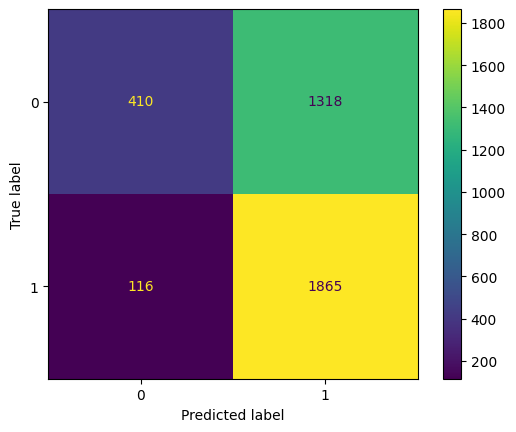

In [ ]:
cm = confusion_matrix(target_test, predictions, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
plt.show()

## Построение кривой precission-recall

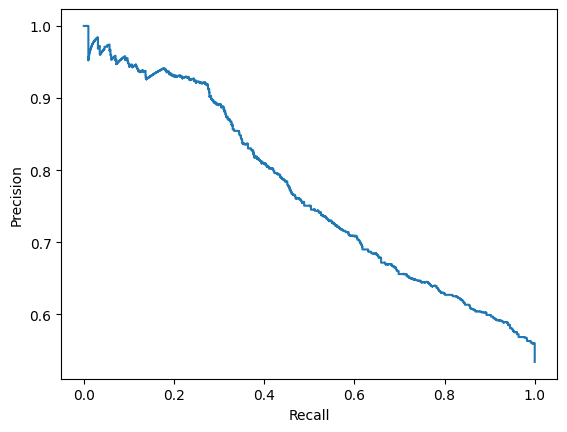

In [ ]:
predictions = pipeline.predict_proba(features_test)[:, 1]
precision, recall, _ = precision_recall_curve(target_test, predictions)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

## Важность признаков

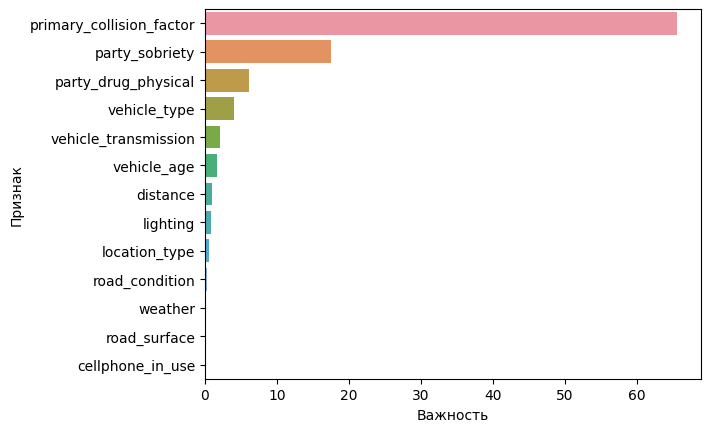

In [ ]:
importances = pd.DataFrame({'features': pipeline[-1].feature_names_, 'scores': pipeline[-1].feature_importances_}).sort_values(by='scores', ascending=False)
sns.barplot(importances, x='scores', y='features', orient='h')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

График зависимости количества аварий от причины аварии:

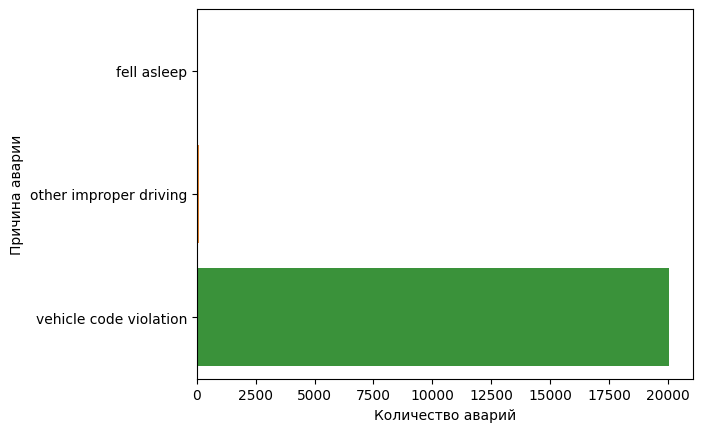

In [ ]:
pivot = df[df.at_fault == 1].pivot_table(index='primary_collision_factor', values='at_fault',  aggfunc='count').reset_index()
sns.barplot(pivot, x='at_fault', y='primary_collision_factor', orient='h')
plt.xlabel('Количество аварий')
plt.ylabel('Причина аварии')
plt.show()

Основным фактором аварий является несоблюдение правил ДТП. Для предотвращения новых проишествий предлагается ввести дополнительную систему мотивации, поощеряющая соблюдение правил движения.

# Выводы

В результате проработки задачи была разработана модель для оценки риска ДТП. Для улучшения качества модели предлагается добавить признаки водителя -  например, возраст, пол, семейное положение, стаж вождения и тп.